In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import os

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

In [2]:
# Get current working directory
print("Current working directory:", os.getcwd())

# Construct absolute paths
base_dir = os.path.dirname(os.getcwd())  # Go up one level from notebooks
data_path = os.path.join(base_dir, 'results_run6')

si_path = os.path.join(data_path, 'small_matrix_si_influence.csv')
sir_path = os.path.join(data_path, 'small_matrix_sir_influence.csv')

print("SI file exists:", os.path.exists(si_path))
print("SIR file exists:", os.path.exists(sir_path))

# Then load with these paths
si_data = pd.read_csv(si_path)
sir_data = pd.read_csv(sir_path)

print("SI Data columns:", si_data.columns.tolist())
print("SIR Data columns:", sir_data.columns.tolist())
print(f"SI data shape: {si_data.shape}")
print(f"SIR data shape: {sir_data.shape}")

# Since network metrics are the same, we'll use the ones from SI data
# Rename columns to avoid conflicts during merge
si_data_renamed = si_data.rename(columns={
    'strength': 'strength',
    'pagerank': 'pagerank'
})

sir_data_renamed = sir_data.rename(columns={
    'strength': 'strength_sir',  # Temporary, will be dropped
    'pagerank': 'pagerank_sir'   # Temporary, will be dropped
})

# Merge the datasets on user_id
merged_data = pd.merge(si_data_renamed, sir_data_renamed, on='user_id', suffixes=('', '_sir'))

# Drop the duplicate network metrics from SIR data since they're the same
merged_data = merged_data.drop(['strength_sir', 'pagerank_sir'], axis=1)

print(f"Merged data shape: {merged_data.shape}")
print("\nFirst few rows of merged data:")
print(merged_data.head())

Current working directory: c:\Users\danie\Documents\Local_Gits\complex-networks\notebooks
SI file exists: True
SIR file exists: True
SI Data columns: ['user_id', 'time_to_10', 'time_to_25', 'time_to_50', 'time_to_90', 'std_time_10', 'std_time_25', 'std_time_50', 'final_size', 'strength', 'pagerank']
SIR Data columns: ['user_id', 'final_outbreak', 'std_outbreak', 'attack_rate', 'epidemic_probability', 'peak_infection', 'time_to_peak', 'duration', 'R0', 'growth_rate', 'strength', 'pagerank']
SI data shape: (1157, 11)
SIR data shape: (1157, 12)
Merged data shape: (1157, 20)

First few rows of merged data:
   user_id  time_to_10  time_to_25  time_to_50  time_to_90  std_time_10  \
0      136         1.0         1.0         1.0         1.0          0.0   
1     7007         1.0         1.0         1.0         1.0          0.0   
2     6736         1.0         1.0         1.0         1.0          0.0   
3     6330         1.0         1.0         1.0         1.0          0.0   
4     6435     

In [3]:
# Define the metrics we want to analyze
si_metrics = ['time_to_10', 'time_to_25', 'time_to_50', 'time_to_90', 
              'std_time_10', 'std_time_25', 'std_time_50', 'final_size']

sir_metrics = ['final_outbreak', 'std_outbreak', 'attack_rate', 
               'epidemic_probability', 'peak_infection', 'time_to_peak', 
               'duration', 'R0', 'growth_rate']

network_metrics = ['strength', 'pagerank']  # Same for both models

In [4]:
# Function to calculate correlations
def calculate_correlations(data, metrics1, metrics2, method='pearson'):
    """Calculate correlations between two sets of metrics"""
    correlations = []
    
    for metric1 in metrics1:
        for metric2 in metrics2:
            # Remove any rows with NaN values for these two metrics
            clean_data = data[[metric1, metric2]].dropna()
            
            if len(clean_data) > 1:  # Need at least 2 points for correlation
                if method == 'pearson':
                    corr, p_value = pearsonr(clean_data[metric1], clean_data[metric2])
                else:  # spearman
                    corr, p_value = spearmanr(clean_data[metric1], clean_data[metric2])
                
                correlations.append({
                    'metric1': metric1,
                    'metric2': metric2,
                    'correlation': corr,
                    'p_value': p_value,
                    'n_samples': len(clean_data)
                })
    
    return pd.DataFrame(correlations)

# Calculate correlations between SI metrics and network metrics
print("Calculating correlations between SI metrics and network metrics...")
si_network_corr = calculate_correlations(merged_data, si_metrics, network_metrics)
si_network_corr_sorted = si_network_corr.sort_values('correlation', key=abs, ascending=False)

print("\nTop 10 SI-Network correlations (absolute value):")
print(si_network_corr_sorted.head(10).to_string(index=False))

# Calculate correlations between SIR metrics and network metrics
print("\nCalculating correlations between SIR metrics and network metrics...")
sir_network_corr = calculate_correlations(merged_data, sir_metrics, network_metrics)
sir_network_corr_sorted = sir_network_corr.sort_values('correlation', key=abs, ascending=False)

print("\nTop 10 SIR-Network correlations (absolute value):")
print(sir_network_corr_sorted.head(10).to_string(index=False))

# Calculate correlations between SI and SIR metrics
print("\nCalculating correlations between SI and SIR metrics...")
si_sir_corr = calculate_correlations(merged_data, si_metrics, sir_metrics)
si_sir_corr_sorted = si_sir_corr.sort_values('correlation', key=abs, ascending=False)

print("\nTop 10 SI-SIR correlations (absolute value):")
print(si_sir_corr_sorted.head(10).to_string(index=False))

Calculating correlations between SI metrics and network metrics...

Top 10 SI-Network correlations (absolute value):
    metric1  metric2  correlation       p_value  n_samples
 final_size strength     0.700007 4.386022e-171       1157
 final_size pagerank     0.670059 1.171196e-151       1157
 time_to_90 strength     0.662578 3.720453e-147       1157
std_time_10 pagerank    -0.661356 1.966418e-146       1157
std_time_10 strength    -0.656367 1.624641e-143       1157
std_time_50 strength    -0.652069 4.777763e-141       1157
std_time_50 pagerank    -0.637331 7.027997e-133       1157
 time_to_90 pagerank     0.633121 1.254957e-130       1157
 time_to_25 strength     0.591604 3.606586e-110       1157
 time_to_50 strength     0.564296  2.953855e-98       1157

Calculating correlations between SIR metrics and network metrics...

Top 10 SIR-Network correlations (absolute value):
             metric1  metric2  correlation       p_value  n_samples
                  R0 strength     0.961965  0.


Plotting top SI-Network correlations...


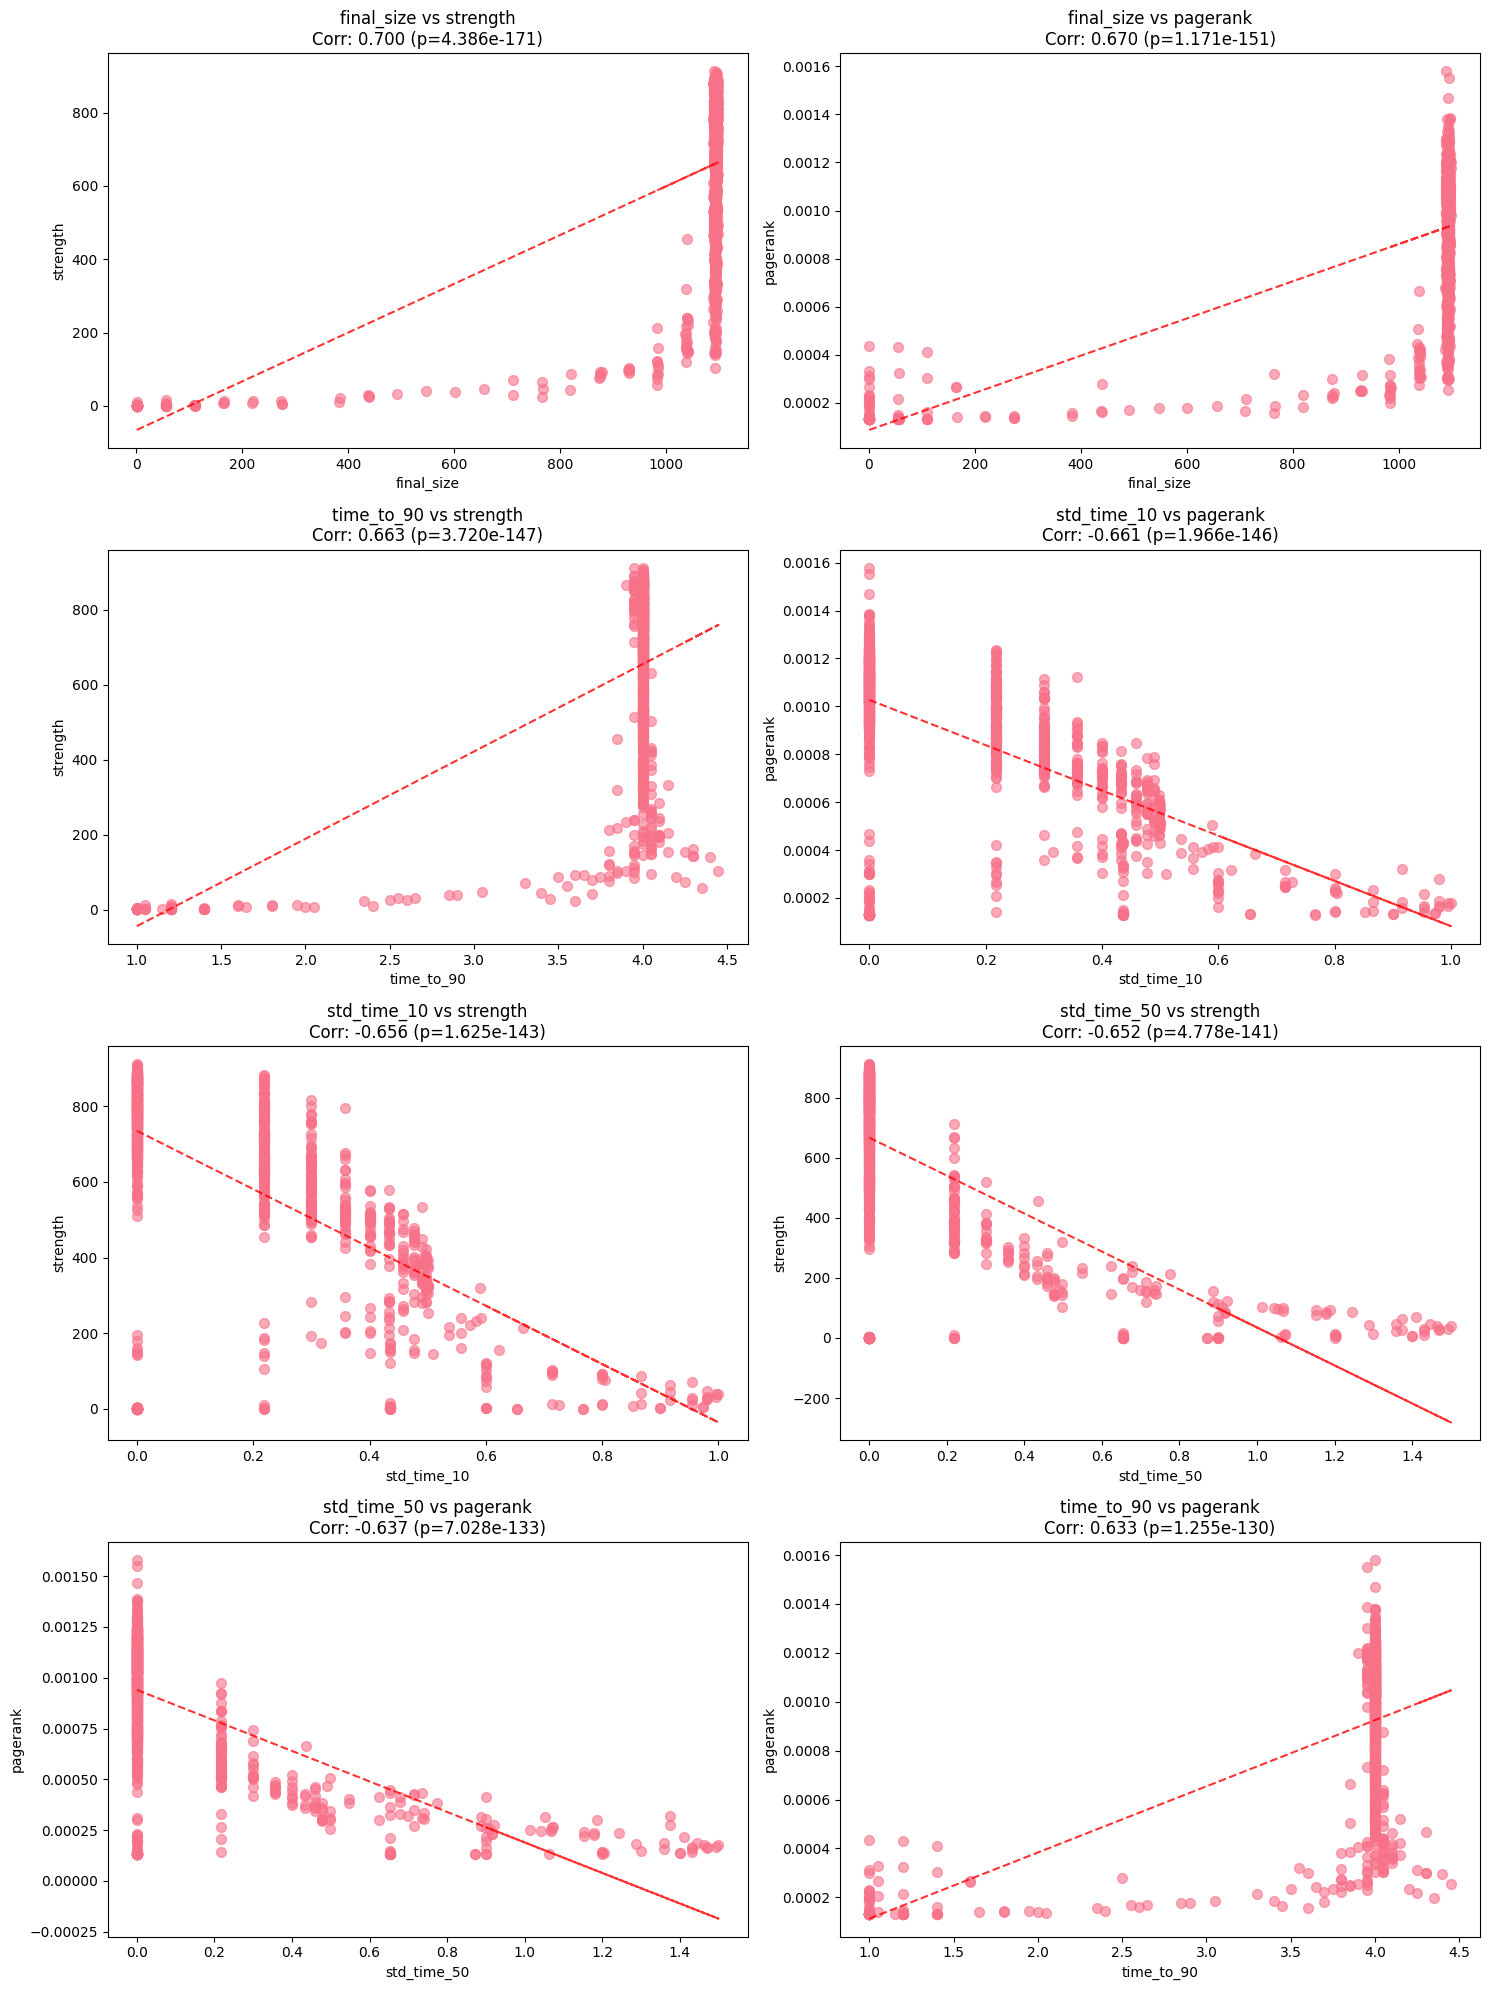


Plotting top SIR-Network correlations...


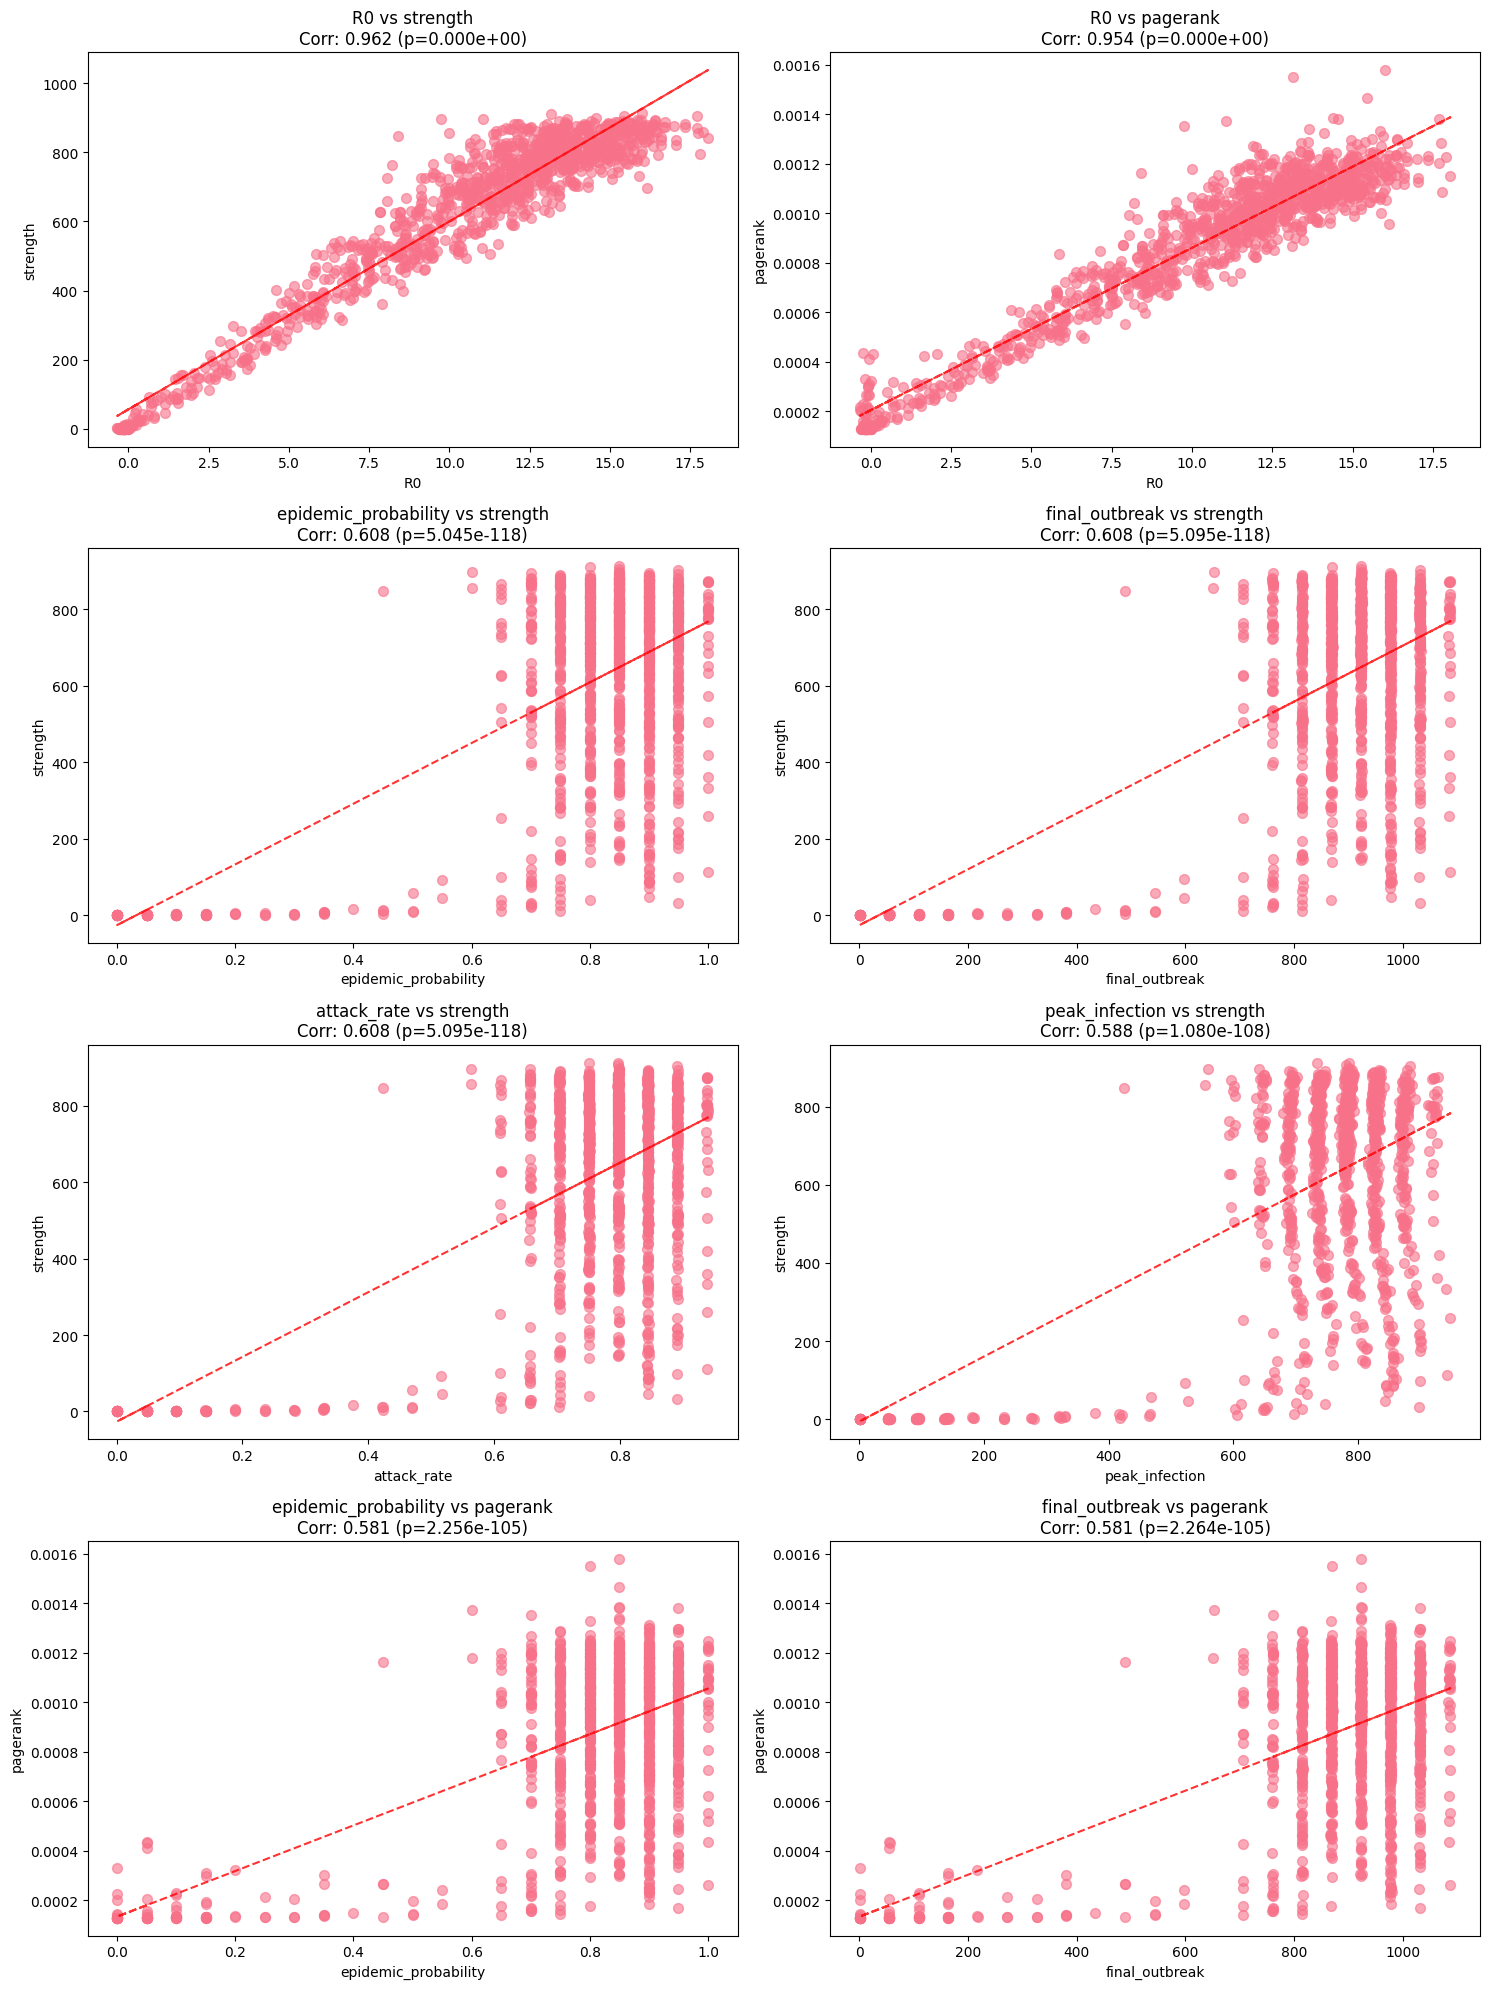


Plotting top SI-SIR correlations...


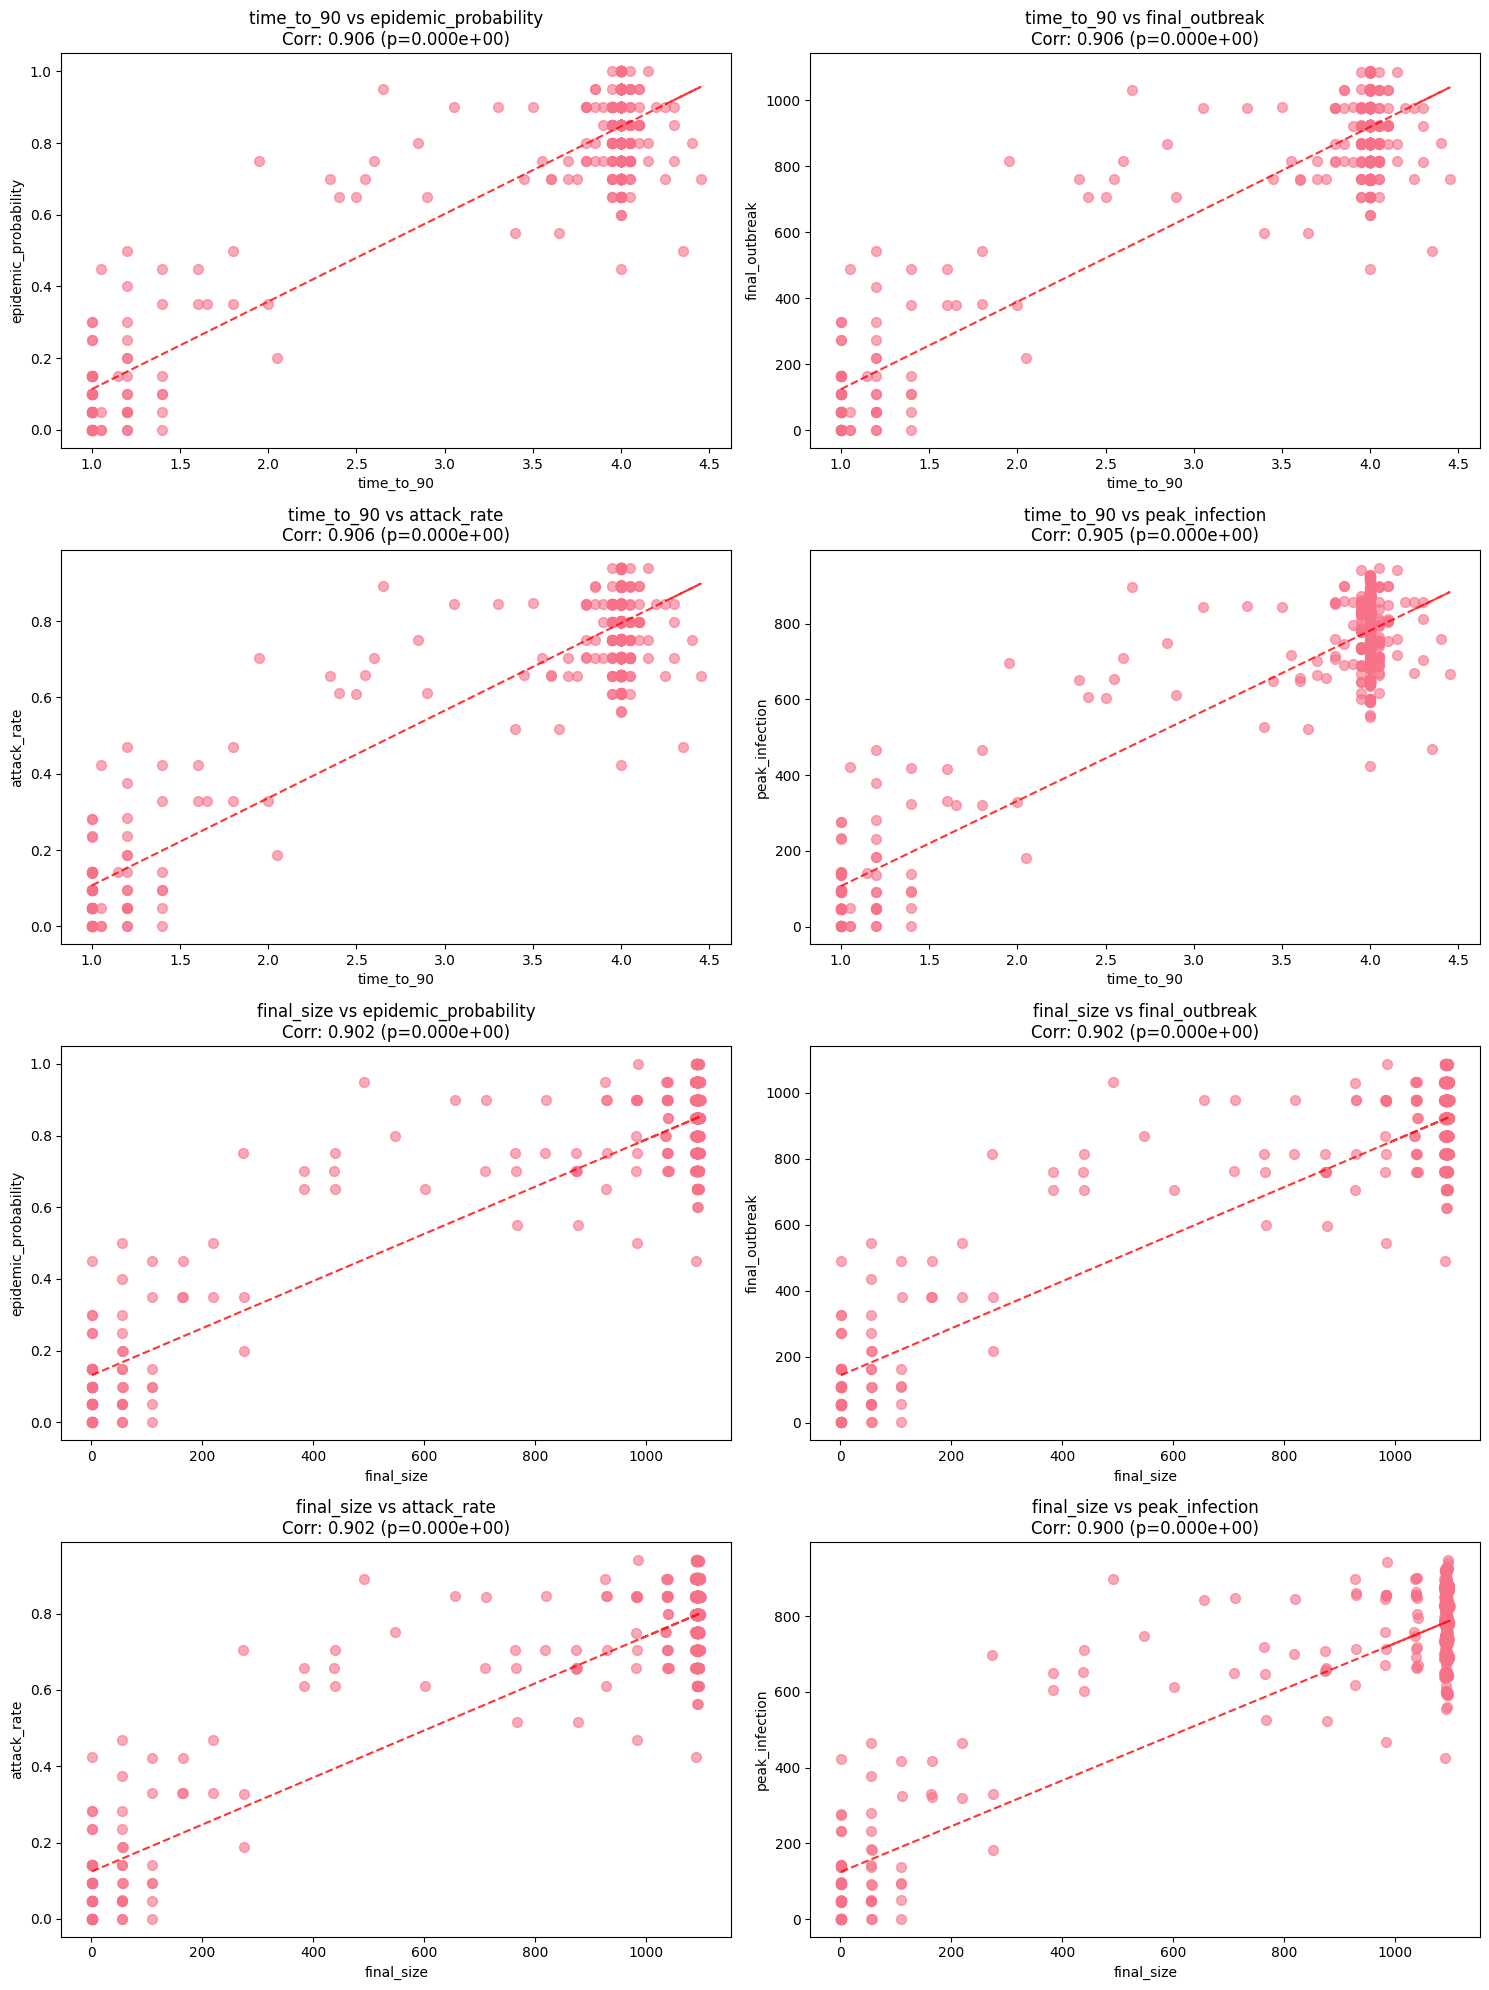

In [5]:
# Function to create scatter plots for interesting correlations
def plot_interesting_correlations(data, correlation_df, top_n=8):
    """Plot scatter plots for the top correlations"""
    top_correlations = correlation_df.head(top_n)
    
    n_plots = len(top_correlations)
    n_cols = 2
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_plots > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for idx, (_, row) in enumerate(top_correlations.iterrows()):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        metric1 = row['metric1']
        metric2 = row['metric2']
        corr = row['correlation']
        p_val = row['p_value']
        
        clean_data = data[[metric1, metric2]].dropna()
        
        ax.scatter(clean_data[metric1], clean_data[metric2], alpha=0.6, s=50)
        ax.set_xlabel(metric1)
        ax.set_ylabel(metric2)
        ax.set_title(f'{metric1} vs {metric2}\nCorr: {corr:.3f} (p={p_val:.3e})')
        
        # Add trend line
        if len(clean_data) > 1:
            z = np.polyfit(clean_data[metric1], clean_data[metric2], 1)
            p = np.poly1d(z)
            ax.plot(clean_data[metric1], p(clean_data[metric1]), "r--", alpha=0.8)
    
    # Hide empty subplots
    for idx in range(len(top_correlations), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Plot interesting correlations
print("\nPlotting top SI-Network correlations...")
plot_interesting_correlations(merged_data, si_network_corr_sorted)

print("\nPlotting top SIR-Network correlations...")
plot_interesting_correlations(merged_data, sir_network_corr_sorted)

print("\nPlotting top SI-SIR correlations...")
plot_interesting_correlations(merged_data, si_sir_corr_sorted)


Creating comprehensive correlation heatmap...


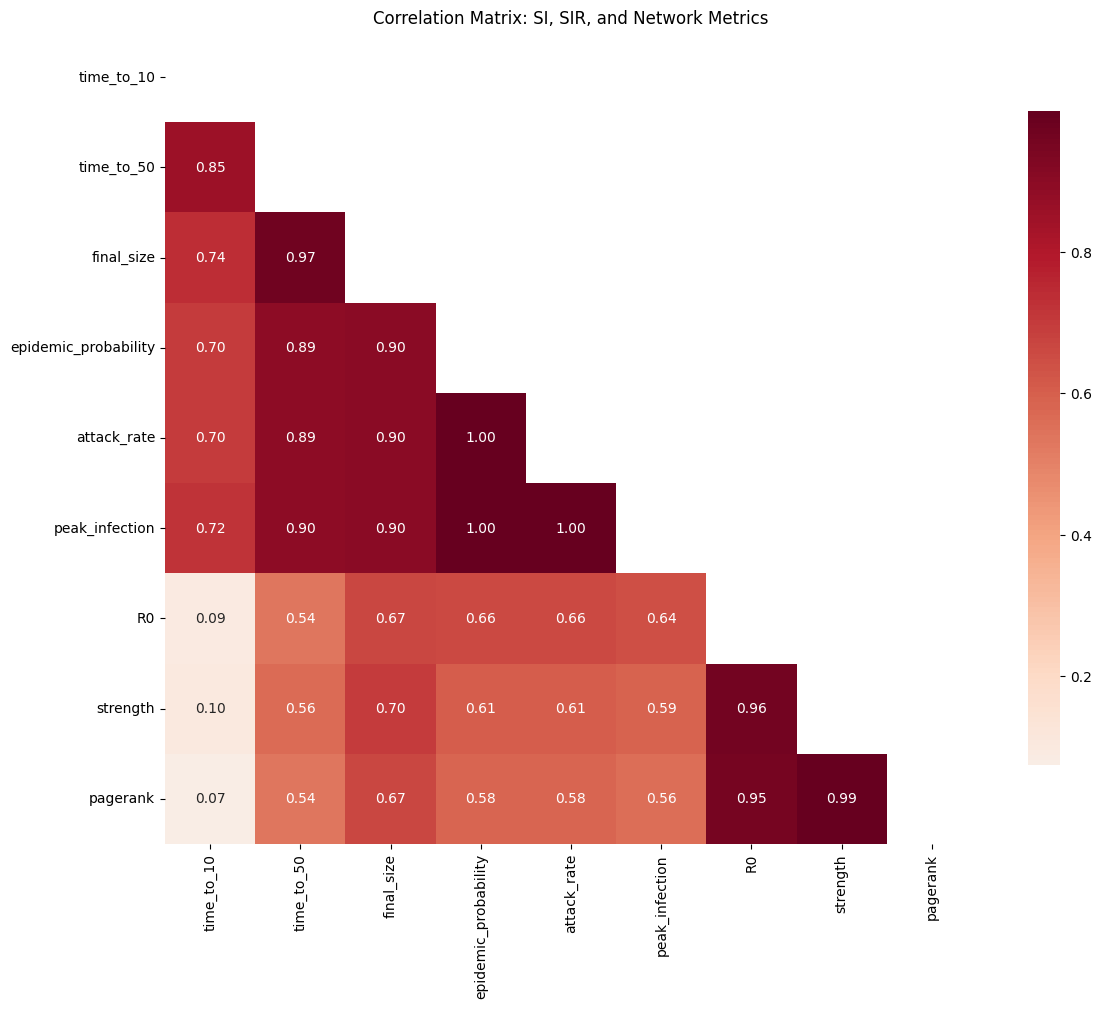

In [6]:
# Create a comprehensive correlation matrix for visualization
print("\nCreating comprehensive correlation heatmap...")

# Select key metrics for the heatmap
key_metrics = [
    'time_to_10', 'time_to_50', 'final_size',  # SI metrics
    'epidemic_probability', 'attack_rate', 'peak_infection', 'R0',  # SIR metrics
    'strength', 'pagerank'  # Network metrics (same for both)
]

# Filter to only include columns that exist in the data
available_metrics = [m for m in key_metrics if m in merged_data.columns]

corr_matrix = merged_data[available_metrics].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix: SI, SIR, and Network Metrics')
plt.tight_layout()
plt.show()

In [8]:
# Print summary statistics
print("\nSummary Statistics:")
print("="*50)
print("SI Metrics:")
si_cols = [col for col in merged_data.columns if col in si_metrics or col in ['strength', 'pagerank']]
print(merged_data[si_cols].describe())
print("\nSIR Metrics:")
sir_cols = [col for col in merged_data.columns if col in sir_metrics]
print(merged_data[sir_cols].describe())
print("\nNetwork Metrics:")
network_cols = [col for col in merged_data.columns if col in network_metrics]
print(merged_data[network_cols].describe())


Summary Statistics:
SI Metrics:
        time_to_10   time_to_25   time_to_50   time_to_90  std_time_10  \
count  1157.000000  1157.000000  1157.000000  1157.000000  1157.000000   
mean      2.045246     2.793215     2.879905     3.776793     0.171900   
std       0.351620     0.489504     0.511050     0.755430     0.226047   
min       1.000000     1.000000     1.000000     1.000000     0.000000   
25%       2.000000     2.850000     3.000000     4.000000     0.000000   
50%       2.000000     2.950000     3.000000     4.000000     0.000000   
75%       2.100000     3.000000     3.000000     4.000000     0.300000   
max       3.000000     3.250000     3.700000     4.450000     1.000000   

       std_time_25  std_time_50   final_size     strength     pagerank  
count  1157.000000  1157.000000  1157.000000  1157.000000  1157.000000  
mean      0.216309     0.101258  1005.497753   602.826908     0.000864  
std       0.245808     0.274152   279.527579   265.637966     0.000323  
min     